<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 19 - Prevendo a Média Mensal de Vendas - Otimização do Modelo SARIMA com Variável Exógena</font></b></strong>

Uma maneira de melhorar o desempenho do modelo é adicionar uma variável exógena. Embora não seja garantia de melhoria, isso pode deixar o modelo mais preciso no forecast, pois mais um fator será considerado na previsão ao longo do tempo.

Uma variável exógena é uma variável que não está sendo sendo prevista na série. Por exemplo: se estamos prevendo o volume de vendas, uma variável que indica se o dia é feriado ou não, seria uma variável exógena. Aliás, é exatamente isso que vamos fazer.

Python possui um pacote de feriados (chamado holidays) que pode ser importado e usado para determinar se uma data foi ou não um feriado.

O modelo SARIMAX que usamos até agora aceita variáveis exógenas como um argumento adicional.


Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.

!pip install -q -U watermark

You should consider upgrading via the 'c:\users\rodolfo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
# Install Package
!pip install -q holidays

You should consider upgrading via the 'c:\users\rodolfo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
# The new versions of Pandas and Matplotlib bring several warning messages to the developer. Let's disable this.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports for data manipulation
import numpy as np
import pandas as pd
import itertools
from pandas import Series
import holidays

# Imports for data Vasualization
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports for predictive modeling
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Imports for metrics and model performance
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports for formatting graphics
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
#Versions of packages used in this jupyter notebook
%reload_ext watermark
%watermark -a "Data Scientist Rodolfo Terra" --iversions

Author: Data Scientist Rodolfo Terra

numpy      : 1.18.2
sys        : 3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]
matplotlib : 3.3.1
sklearn    : 0.23.2
plotly     : 4.13.0
statsmodels: 0.12.1
holidays   : 0.10.4
seaborn    : 0.12.0.dev0
pandas     : 1.1.1
scipy      : 1.4.1



## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

### Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [4]:
# Load the data
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [5]:
# shape
dados.shape

(9994, 21)

In [7]:
# Columns
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [8]:
# View the data
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [9]:
# Statistical Summart
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [10]:
# Chacking missing values - we have no missing values in the dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [11]:
# Adjusting the column names so that they are all lowercrase
dados.columns = map(str.lower, dados.columns)

In [12]:
# We will replace the spaces and dashes in the columnb names with '-'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [13]:
# Checking out 
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [14]:
# Let's check the unique values per column (to help define whether the variable is categorical  or not)
for c in dados.columns:
    if len(set(dados[c])) < 20:
        print(c,set(dados[c]))

ship_mode {'Standard Class', 'Same Day', 'Second Class', 'First Class'}
segment {'Home Office', 'Corporate', 'Consumer'}
country {'United States'}
region {'South', 'Central', 'East', 'West'}
category {'Technology', 'Office Supplies', 'Furniture'}
sub_category {'Labels', 'Envelopes', 'Tables', 'Phones', 'Binders', 'Paper', 'Copiers', 'Bookcases', 'Art', 'Accessories', 'Appliances', 'Furnishings', 'Machines', 'Fasteners', 'Storage', 'Supplies', 'Chairs'}
quantity {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
discount {0.0, 0.8, 0.2, 0.3, 0.45, 0.5, 0.7, 0.6, 0.32, 0.1, 0.4, 0.15}


## E os Feriados?

Todas as vendas ocorrem nos EUA. Será que o fato de ser feriado de alguma forma contribui para a previsão de vendas? 

Não temos em nosso dataset nenhuma variável com esta informação e teremos que buscá-la externamente ao dataset. Em linhas gerais, isso é o que chamados de variável exógena.

De fato, teremos duas séries: uma com a data e a venda (que trabalhamos até aqui) e uma nova série com a data e a indicacão se aquela data foi feriado ou não. Vai dar um trabalhinho, mas é para isso que estamos aqui. Para resolver problemas. Vou mostrar tudo em detalhes para você.

E o interessante é que nem tudo vai sair como esperado! 

Vamos checar a primeira e última data de vendas.

In [16]:
# Firt Sales date in the dataset
dados['order_date'].min()

'2014-01-03'

In [17]:
# Last Sales date in the dataset
dados['order_date'].max()

'2017-12-30'

Temos vendas do começo de 2014 ao fim de 2017. Vamos buscar os feriados nesse período.

O pacote holidays (que também permite coletar feriados do Brasil) torna nossa vida um pouco mais fácil. Observe:

In [20]:
# We will pick up all holidays in tyhe US between 2014 to 2017 
for i, feriado in holidays.US(years = [2014, 2015, 2016, 2017]).items():
    print(i, feriado)

2016-01-01 New Year's Day
2016-01-18 Martin Luther King Jr. Day
2016-02-15 Washington's Birthday
2016-05-30 Memorial Day
2016-07-04 Independence Day
2016-09-05 Labor Day
2016-10-10 Columbus Day
2016-11-11 Veterans Day
2016-11-24 Thanksgiving
2016-12-25 Christmas Day
2016-12-26 Christmas Day (Observed)
2017-01-01 New Year's Day
2017-01-02 New Year's Day (Observed)
2017-01-16 Martin Luther King Jr. Day
2017-02-20 Washington's Birthday
2017-05-29 Memorial Day
2017-07-04 Independence Day
2017-09-04 Labor Day
2017-10-09 Columbus Day
2017-11-11 Veterans Day
2017-11-10 Veterans Day (Observed)
2017-11-23 Thanksgiving
2017-12-25 Christmas Day
2014-01-01 New Year's Day
2014-01-20 Martin Luther King Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day
2015-01-01 New Year's Day
2015-01-19 Martin Luther King Jr. Day
2015-02-16 Washington's Bir

Hummm...muitos feriados. Foram 44 para ser exato. Vamos criar uma série para armazenar as datas dos feriados entre 2014 e 2017.

Para conhecer mais sobre o pacote holidays, acesse: https://pypi.org/project/holidays/

In [21]:
# Create an empty dataframe
feriados = pd.Series()

In [25]:
# We will pick up all holidays in tyhe US between 2014 to 2017 
for i, feriado in holidays.US(years = [2014, 2015, 2016, 2017]).items():
    feriados[i] = feriado

In [26]:
# View the data
feriados.head(8)

2016-01-01                New Year's Day
2016-01-18    Martin Luther King Jr. Day
2016-02-15         Washington's Birthday
2016-05-30                  Memorial Day
2016-07-04              Independence Day
2016-09-05                     Labor Day
2016-10-10                  Columbus Day
2016-11-11                  Veterans Day
dtype: object

In [39]:
# Let's convert the series to a dataframe and make some adjustments
feriados_df = pd.DataFrame(feriados)

In [42]:
# Type
type(feriados_df)

pandas.core.frame.DataFrame

In [41]:
# Shape
feriados_df.shape

(44, 1)

In [45]:
# Index reset to adjust column names
feriados_df.reset_index(level = 0, inplace = True)

In [46]:
# Adjust the name of the columns
feriados_df.columns = ['data_feriado','feriado']

In [48]:
# View
feriados_df.head()

,data_feriado,feriado
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-15,Washington's Birthday
3,2016-05-30,Memorial Day
4,2016-07-04,Independence Day


In [49]:
#Type
feriados_df.dtypes

data_feriado    object
feriado         object
dtype: object

In [51]:
# Let's leave the date column as a datetime type, as we will need this in a litle while
feriados_df['data_feriado'] = pd.to_datetime(feriados_df['data_feriado'])

Perfeito. Já temos a série com os feriados.

Devemos adicionar ao nosso dataset agora? A resposta é não, pois não estamos usando o dataset inteiro, mas sim a média de vendas de produtos de tecnologia. Seria desperdício de recurso e de tempo adcionar agora.

Vamos preparar nossa série de média de vendas (como fizemos nas aulas anteriores) e aí sim adicionaremos a coluna com o feriado. Fique atento.

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [52]:
# Separating data by category

df_tecnologia = dados.loc[dados['category'] == 'Technology']

Agora vamos preparar as séries temporais.

In [53]:
# Aggregating sales by order date
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()

In [54]:
# How is each dataset doing?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [55]:
# Putting the date as an index
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [56]:
# View the serie
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

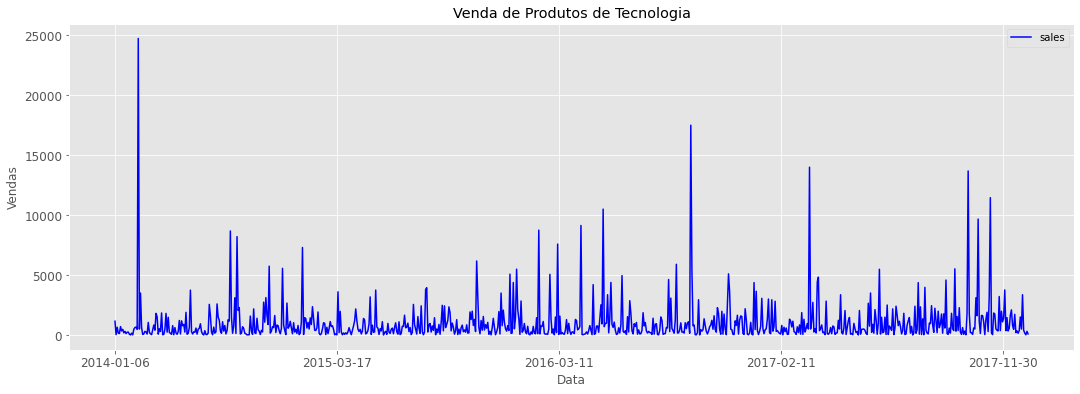

In [57]:
# Sale of technology Products
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo.

In [62]:
# Chaging the index type
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [63]:
# Checking the index type
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [64]:
# Checking the index type
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [65]:
# Resampling data for monthly frequency
# Using the average value of daily sales - we define the month as an index
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [66]:
# Checking the resulting type
type(media_vendas_tecnologia)

pandas.core.series.Series

In [67]:
# Checking the data
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

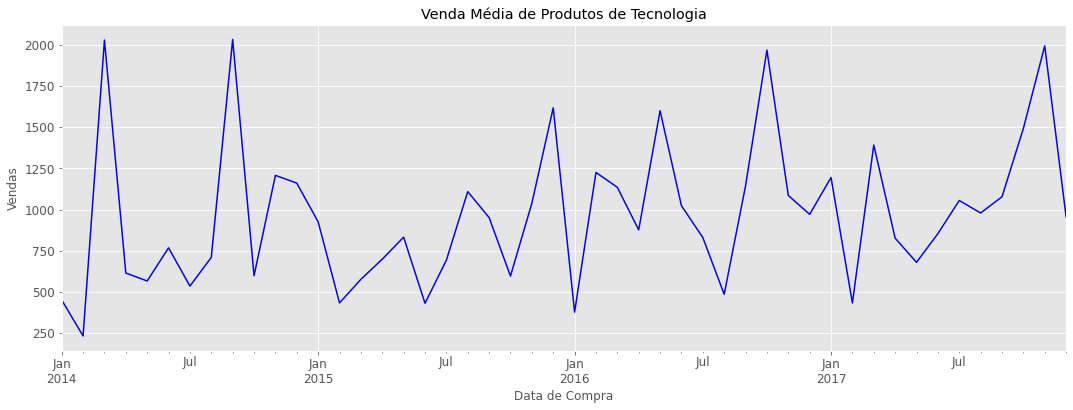

In [68]:
# Average Sale of technology Products
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

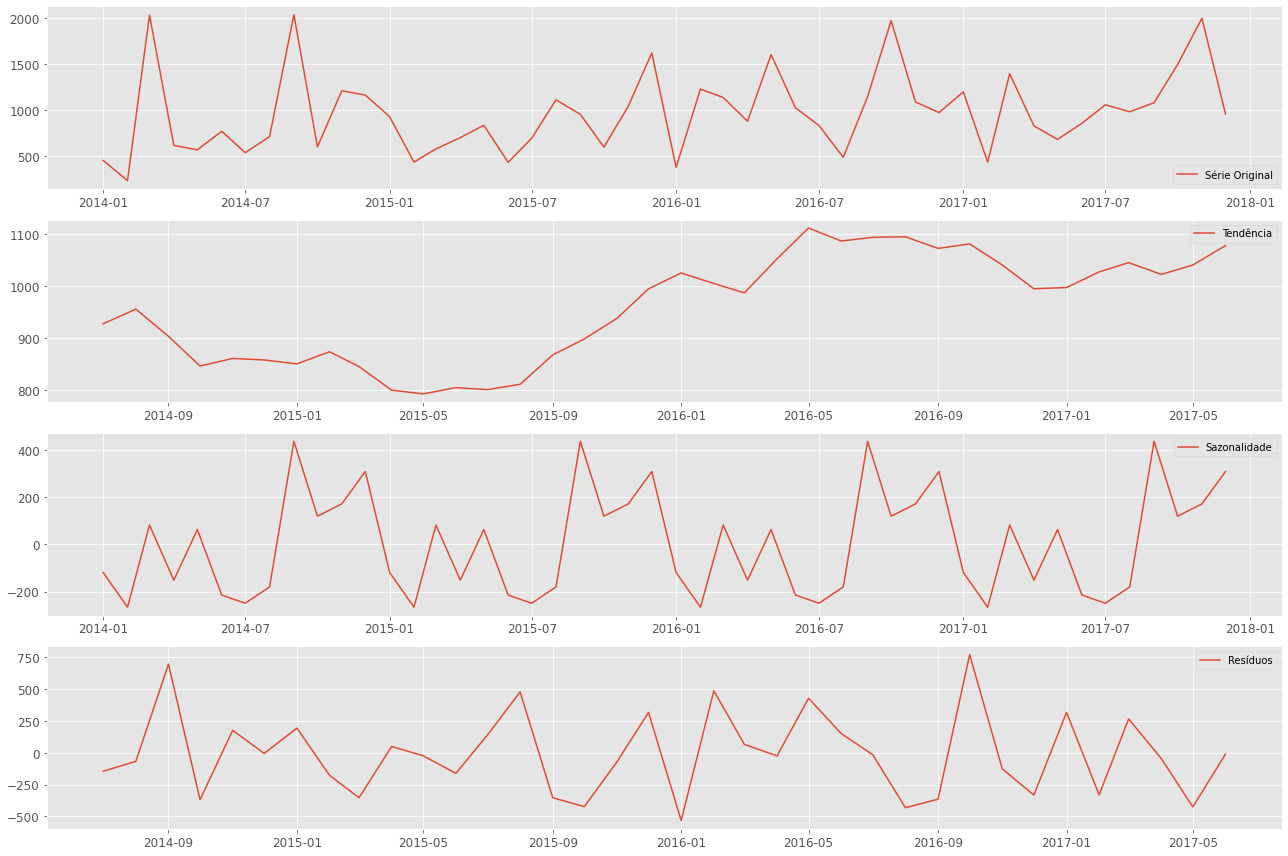

In [69]:
# Decomposition of the average salers time series of technology products
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [70]:
# Function to test stationarity
def testa_estacionaridade(serie):
    
    # Calculates mobile statistics
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot of mobile statistics
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Dickey-Fuller test:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Test
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatting the output
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])


    # Loop for each test output item
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Test the valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

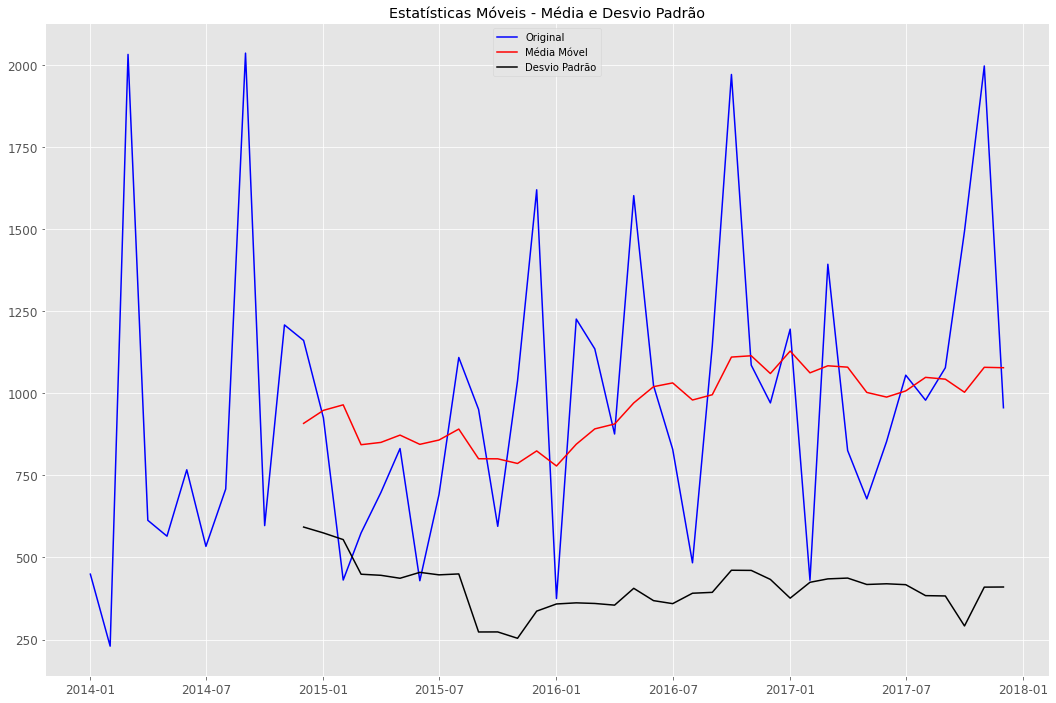


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [71]:
# Chacks whether the series is stationary
testa_estacionaridade(media_vendas_tecnologia)

### Adicionando Feriado (Variável Exógena) a Nossa Série

A função abaixo compara as datas de dois dataframes, nossa série de vendas e nossa série de feriados. Quando a data for igual, preenchemos um vetor com 1 e quando for diferente preenchemos com 0. Simples, não? Criaremos uma variável categórica que será usada como variável exógena.

Mas teremos que converter nossa série em dataframe, fazer a operação e depois retornar para série.

In [75]:
# Function
def adiciona_feriado(x):
    #apply the rule
    batch_df = feriados_df.apply(lambda y: 1 if (x['order_date'] == y['data_feriado']) else None, axis = 1)
    
    # Clear null values
    batch_df = batch_df.dropna(axis = 0, how = 'all')
    
    # If empty, fill in with 0
    if batch_df.empty:
        batch_df = 0
    else:
        batch_df = batch_df.to_string(index = False)
        
    return batch_df

In [76]:
# Confirms the object type
type(media_vendas_tecnologiacnologia)

pandas.core.series.Series

In [79]:
# Create a dataset from the series
media_vendas_tecnologia_df = pd.DataFrame(media_vendas_tecnologia)

In [80]:
# Confirm the object type
type(media_vendas_tecnologia_df)

pandas.core.frame.DataFrame

In [82]:
# Index reset to adjust the columns
media_vendas_tecnologia_df.reset_index(level = 0, inplace = True)

In [83]:
# Adjust the name of the columns
media_vendas_tecnologia_df.columns = ['order_date','sales']

In [84]:
# View
media_vendas_tecnologia_df.head(3)

,order_date,sales
0,2014-01-01,449.041429
1,2014-02-01,229.787143
2,2014-03-01,2031.948375


In [85]:
# Type
media_vendas_tecnologia_df.dtypes

order_date    datetime64[ns]
sales                float64
dtype: object

In [87]:
# We apply the function and create the holidays column
media_vendas_tecnologia_df['feriado'] = media_vendas_tecnologia_df.apply(adiciona_feriado, axis = 1)

In [88]:
# View
media_vendas_tecnologia_df.head(3)

,order_date,sales,feriado
0,2014-01-01,449.041429,1.0
1,2014-02-01,229.787143,0
2,2014-03-01,2031.948375,0


Está ficando bonito. Mas não gostei do valor float em 1.0. Isso vai atrapalhar meus planos. Temos solução para isso também.

In [90]:
# Converting the holiday column to an integer
media_vendas_tecnologia_df['feriado'] = pd.to_numeric(media_vendas_tecnologia_df['feriado'], downcast = 'integer')

In [91]:
# View
media_vendas_tecnologia_df.head(3)

,order_date,sales,feriado
0,2014-01-01,449.041429,1
1,2014-02-01,229.787143,0
2,2014-03-01,2031.948375,0


In [93]:
# Let's define order_date as an index
media_vendas_tecnologia_df.set_index('order_date', inplace = True)

In [94]:
# View
media_vendas_tecnologia_df.head(3)

,sales,feriado
order_date,,
2014-01-01,449.041429,1
2014-02-01,229.787143,0
2014-03-01,2031.948375,0


In [96]:
#I will deletre the original serie
del media_vendas_tecnologia

In [97]:
# and Create it
media_vendas_tecnologia = media_vendas_tecnologia_df

In [99]:
# View
media_vendas_tecnologia

,sales,feriado
order_date,,
2014-01-01,449.041429,1
2014-02-01,229.787143,0
2014-03-01,2031.948375,0
2014-04-01,613.028933,0
2014-05-01,564.698588,0
2014-06-01,766.905909,0
2014-07-01,533.608933,0
2014-08-01,708.435385,0
2014-09-01,2035.838133,1


Opa.

Tem algo estranho.

Perceba que a variável exógena aqui não vai funcionar como esperado, pois como nossa série é mensal, a data de venda é sempre o primeiro dia de cada mês e na prática, somente o dia 01 de Janeiro é feriado em cada ano. Para séries de médias mensais uma variáve exógena indicado feriado não parece adequada. Concorda? Claro que podemos trabalhar com a série original de vendas, mas aí estaríamos prevendo a série diária e não mensal.

Mas vamos seguir em frente pois quero mostrar algo interessante a você.

### Dividindo os Dados em Treino e Teste

In [100]:
# Devision in training and testing
X = media_vendas_tecnologia
train_size = int(len(X) * 0.75)
trainset, testset = X[0:train_size], X[train_size:]

In [101]:
len(trainset)

36

In [102]:
len(testset)

12

Precisamos de um passo adicional aqui, pois a variável exógena não pode ser incluída como variável de dados (simplesmente porque ela não é). O que queremos prever é o total em vendas e não os feriados, certo?

In [104]:
# We put only salçes in the data series
dados_treino = pd.Series(trainset['sales'])

In [105]:
# And only holiday (plus a constant required by statsmodels) in the holiday series
exog_var_treino = sm.add_constant(trainset['feriado'])

In [107]:
# Type
type(exog_var_treino)

pandas.core.frame.DataFrame

In [109]:
# View the data type of this object
exog_var_treino.dtypes

const      float64
feriado       int8
dtype: object

In [110]:
# View
exog_var_treino.head(3)

,const,feriado
order_date,,
2014-01-01,1.0,1
2014-02-01,1.0,0
2014-03-01,1.0,0


Embora sejam duas séries acima, para o processamento com o Statsmodels, a série de dados deve ficar como tipo série e a série da variável exógena deve ficar como dataframe, ou teremos erro no processamento. Vamos fazer o mesmo com os dados de teste.

In [111]:
# We put only sales as data series
dados_teste = pd.Series(testset['feriado'])

In [112]:
# And only holiday in the holiday series
exog_var_teste = sm.add_constant(testset['feriado'])

Fique atento ao código abaixo e verifique onde incluímos as variáveis exógenas.

### Função Para o Cálculo da Acurácia

In [113]:
# Function
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

## Otimização do Modelo SARIMA com Variável Exógena

### Grid Search Método 2 

Neste método de Grid Search, nós testamos diversas combinações dos hiperparâmetros do modelo SARIMA. Tome cuidado para não exagerar nas combinações. Valores de 0 e 1 resolvem a grande maioria dos problemas.

In [114]:
# We will define p, d and q so that they have values between 0 and 2 and we will test the combinations.
p = d = q = range(0, 2)

Agora geramos diferentes combinações de p, d e q.


In [115]:
# List of combinations of p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [116]:
# List of combinations of seasonal hyperparameters P, D and Q
# We are using List Comprehension
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [117]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [119]:
# Grid Search
warnings.filterwarnings("ignore")

# Lowest possible value for the AIC Statistics (our goal in optimizing the model)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Creates the model whith the combination to hyperparamentes
            mod = sm.tsa.statespace.SARIMAX(dados_treino,
                                            exog_var_treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Training the model
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Collect the lowest AIC value
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:533.4308185633837
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:345.2124475520536
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:364.0768617188458
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:180.79080452834023
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:361.08833351685905
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:346.9042045847437
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:195.54049883217485
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:182.08757729333834
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:518.5675113694467
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:329.66567709247414
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:351.3652394984502
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:163.18307983883474
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:362.47471388964294
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:332.40339575574194
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:197.52806247439318
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:163.48234075210078
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:546.976725709374
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3

In [120]:
# Training the model with best combination of the hyperparamenters 
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(dados_treino,
                                             exog_var_treino,
                                             order = (0, 1, 1),
                                             seasonal_order = (0, 1, 1, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility=False)

In [121]:
# Training (Fit) of the model
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [122]:
# Template summary
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -69.830
Date:                            Tue, 05 Jan 2021   AIC                            149.659
Time:                                    18:38:07   BIC                            150.645
Sample:                                01-01-2014   HQIC                           147.531
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6155   1.98e+04     -0.000      1.000   -3.87e+04    3.87e+04
feriado     1287.5176   6051.892   

Perceba que tivemos um leve aumento de 3 pontos na estatística AIC. Não otimizamos o modelo, mas considerando que temos mais um elemento a mais para a previsão, a variável exógena, isso não parece ruim. Mas continue comigo.

In [125]:
# Let's do a step forward 
sarima_predict_2 = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2017-01-01'), 
                                                       end = pd.to_datetime('2017-12-01'),
                                                       exog = exog_var_teste,
                                                       dynamic = False)

In [126]:
# Confidence interval
sarima_predict_conf_2 = sarima_predict_2.conf_int()
sarima_predict_conf_2

,lower sales,upper sales
2017-01-01,-209.449145,2066.538293
2017-02-01,-236.084551,2004.449147
2017-03-01,368.252702,2604.676167
2017-04-01,-84.480790,2151.819311
2017-05-01,144.685209,2380.984568
2017-06-01,-92.227998,2144.074218
2017-07-01,-148.866454,2087.438725
2017-08-01,-69.100404,2167.207743
2017-09-01,106.759998,2343.071188
2017-10-01,215.489265,2451.806085


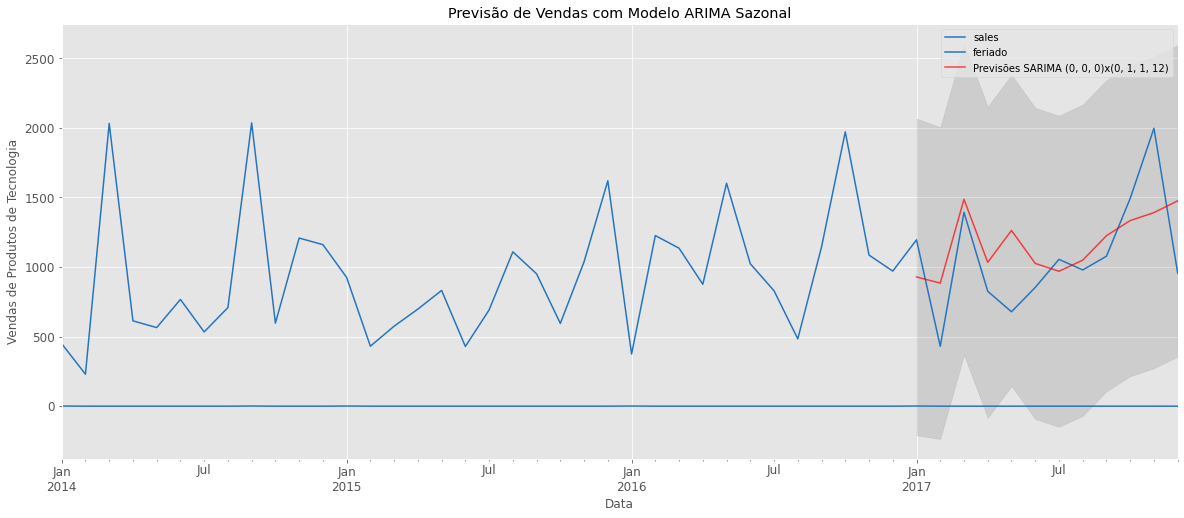

In [127]:
rcParams['figure.figsize'] = 20,8


# Plot of observed values 
ax = media_vendas_tecnologia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot of predicted values
sarima_predict_2.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 0, 0)x(0, 1, 1, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot of Confidence interval 
ax.fill_between(sarima_predict_conf_2.index,
                # lower sales
                sarima_predict_conf_2.iloc[:, 0],
                # upper sales
                sarima_predict_conf_2.iloc[:, 1], color = 'k', alpha = 0.1)

# Title and Legend
plt.title('Previsão de Vendas com Modelo ARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

O modelo parece ter perdido um pouco do padrão da série.

In [129]:
# Calculating performance 
sarima_results = performance(dados_teste, sarima_predict_2.predicted_mean)
sarima_results

MSE das previsões é 1416456.73
RMSE das previsões é 1190.15
MAPE das previsões é inf



Você percebeu que usamos a variável exógena no treino do modelo e na previsão do modelo. Percebeu, certo? Não? Então retorne às células anteriores e perceba!

Precisamos agora preparar a variável exógena para o forecast. Todas as variáveis usadas no treinamento do modelo tem que ser usadas em teste e agora no forecast. Assim como em qualquer modelo de Machine Learning.

In [132]:
# We will pick all US holiday between 2014 to 2017

# Create the serie
feriados_forecast = pd.Series()

# Fetch the holiday
for i, feriado in holidays.US(years = [2017,2018,2019,2020,2021]).items():
    feriados_forecast[i] = feriado

In [134]:
len(feriados_forecast)

57

In [137]:
# View the last lines
feriados_forecast.tail()

2021-10-11                Columbus Day
2021-11-11                Veterans Day
2021-11-25                Thanksgiving
2021-12-25               Christmas Day
2021-12-24    Christmas Day (Observed)
dtype: object

In [139]:
# Let's convert the series to a dayaframe and make some adjustments
feriados_forecast_df = pd.DataFrame(feriados_forecast)

# Index reset to adjust columns names
feriados_forecast_df.reset_index(level = 0, inplace = True)

# Ajusts the column names
feriados_forecast_df.columns = ['data_feriado','feriado']

# Let's convert the date column to the correct type
feriados_forecast_df['data_feriado'] = pd.to_datetime(feriados_forecast_df['data_feriado'])

# Let's set the date as an index
feriados_forecast_df.set_index("data_feriado", inplace = True)

# We don't know which day will be sold (that's what we want to predict), so let's put zero in:
feriados_forecast_df['feriado'] = 0

# Converting the holiday column to integer
feriados_forecast_df['feriado'] = pd.to_numeric(feriados_forecast_df['feriado'], downcast = 'integer')

# And only the holiday (plus a constant required by statsmodels) in the holiday series
exog_var_forecast = sm.add_constant(feriados_forecast_df['feriado'])
exog_var_forecast['feriado'] = 1

# View dataset
exog_var_forecast.head(3)

,const,feriado
data_feriado,,
2017-01-01,1.0,1
2017-01-02,1.0,1
2017-01-16,1.0,1


In [140]:
# Forecast of 60 steps over time (in practice we will reduce it to 57 because we only have 57 holidays)
horizonte_60_predict_2 = modelo_sarima_v2_fit.get_forecast(steps = 57, exog = exog_var_forecast, dynamic = True)

In [141]:
# Confidence Interval
horizonte_60_predict_2_conf_2 = horizonte_60_predict_2.conf_int()
horizonte_60_predict_2_conf_2

,lower sales,upper sales
2017-01-01,-209.449145,2066.538293
2017-02-01,1051.433010,3291.966708
2017-03-01,1655.770264,3892.193729
2017-04-01,1203.036771,3439.336872
2017-05-01,1432.202770,3668.502129
2017-06-01,1195.289563,3431.591779
2017-07-01,1138.651107,3374.956286
2017-08-01,1218.417157,3454.725304
2017-09-01,1394.277559,3630.588749
2017-10-01,1503.006827,3739.323646


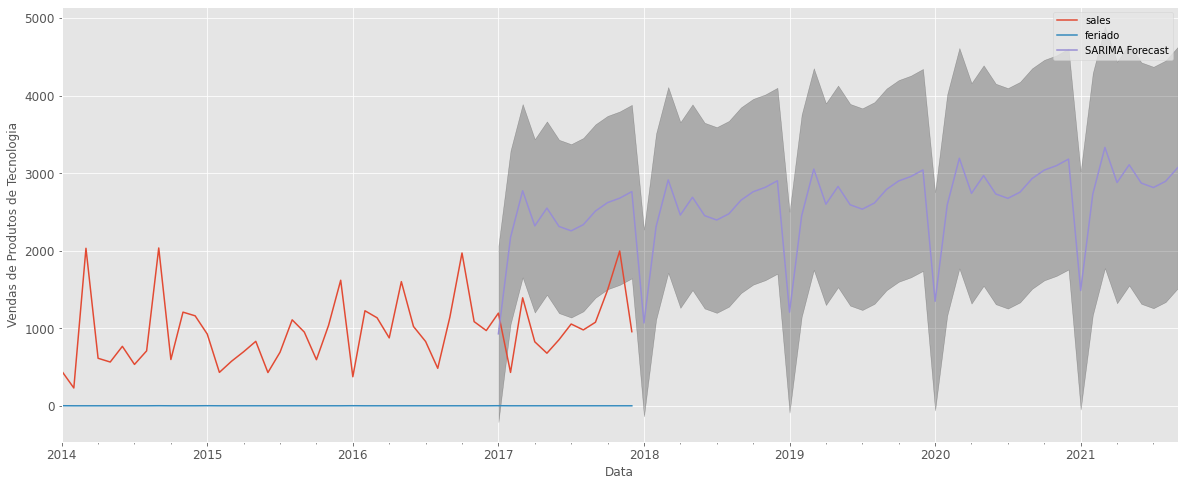

In [142]:
rcParams['figure.figsize'] = 20,8


# Plot of observed values 
ax = media_vendas_tecnologia.plot(label = 'Valores Observados')

# Plot of predicted values
horizonte_60_predict_2.predicted_mean.plot(ax = ax, label = 'SARIMA Forecast')

# Plot of Confidence interval
ax.fill_between(horizonte_60_predict_2_conf_2.index,
                horizonte_60_predict_2_conf_2.iloc[:, 0],
                horizonte_60_predict_2_conf_2.iloc[:, 1], color = 'k', alpha = .25)

# Plot
ax.set_xlabel('Data')
ax.set_ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

E aí está o problema!

Nosso modelo tem um desempenho ruim ao longo do tempo. Isso se explica porque a previsão de vendas é uma média mensal e o feriado não pode ser considerado pelo modelo. Esses picos para baixo são os feriados do dia 01 de janeiro de cada ano, quando a venda é menor. Mas com essa variável exógena o modelo acaba se perdendo na previsão do padrão da série, que é que interessa.

Veja como também aprendemos quando as coisas não saem como esperado. Por isso a experimentação é tão importante em Ciência de Dados.

In [143]:
# Test of the Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.49095878]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%.

No geral, o modelo até tenta fazer as previsões, pois o modelo SARIMA é poderoso, mas a variável exógena aqui está atrapalhando mais do que ajudando.

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA (1,1) - AIC = 550.3 e RMSE = 420.2
- Aula 16 --> Modelo ARIMA (6,0,2) - AIC = 559.4 e RMSE = 401.5
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12)  - AIC = 176.74 e RMSE = 425.89
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12)  - AIC = 146.77 e RMSE = 353.57
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66 e RMSE = 341.23

Aqui chegamos a um dilema comum em séries temporais. Se você estivesse analisando apenas as métricas, escolheria entre os modelos das aulas 18 ou 19? Menor AIC ou menor RMSE? Conforme já conversamos, o RMSE indica a performance do modelo com os dados do dataset e o AIC indica a performance do modelo no forecast, que é o que interessa.

Dos 4 modelos acima, o modelo da Aula 18 é o que deveria ser escolhido como modelo final considerando a família ARIMA.

Agora vamos trocar de modelo. Até a Aula 20.